# Constrained sinusoidal models
> Applying the complex surrogate to models where sinusoidal frequencies are related or constrained

In [1]:
#| default_exp constrained_model

In [91]:
from functools import partial
import math

import IPython.display as ipd
from lapsolver import solve_dense
import matplotlib.pyplot as plt
import torch
from torch import nn

from sinusoidal_gradient_descent.core import fft_loss, estimate_amplitude

In [92]:
class HarmonicModel(nn.Module):
    def __init__(self, n_harmonics):
        super().__init__()
        self.n_harmonics = n_harmonics
        self.register_buffer("k", torch.arange(1, n_harmonics + 1))
        self.amp = nn.Parameter(torch.rand(n_harmonics))
        self.f0 = nn.Parameter(torch.rand(1) * math.pi / n_harmonics)

    def forward(self, n):
        harmonics = (
            self.amp[:, None].abs()
            * torch.cos(self.freq.detach()[:, None] * n[..., None, :])
        )
        return torch.sum(harmonics, dim=-2)
    
    @property
    def freq(self):
        return self.f0 * self.k


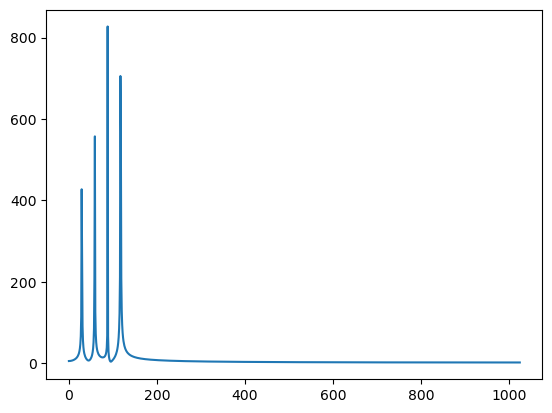

In [93]:
model = HarmonicModel(4)
plt.plot(torch.fft.rfft(model(torch.arange(2048)).detach()).abs())

In [94]:
class SinusoidalModel(nn.Module):
    def __init__(self, n_sinusoids):
        super().__init__()
        self.n_sinusoids = n_sinusoids
        self.amp = nn.Parameter(torch.rand(n_sinusoids))
        self.freq = nn.Parameter(torch.exp(1j * torch.rand(n_sinusoids) * math.pi))
    
    def forward(self, n):
        return torch.sum(self.amp[:, None].abs() * (self.freq[:, None] ** n[..., None, :]).real, dim=-2)

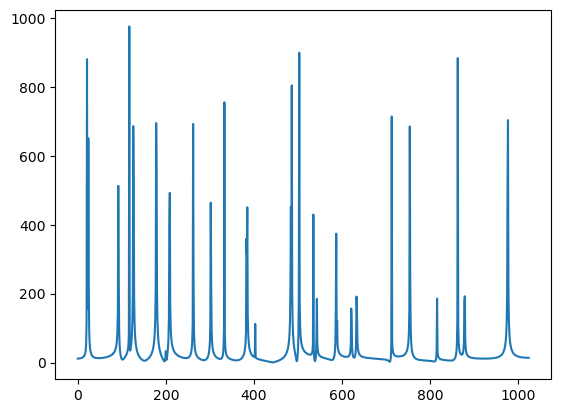

In [95]:
model = SinusoidalModel(32)
plt.plot(torch.fft.rfft(model(torch.arange(2048)).detach()).abs())

In [96]:
def min_lap_cost(x, y, p, q):
    cost = torch.cdist(x[..., None], y[..., None], p=2)
    pq_cost = torch.cdist(p[..., None], q[..., None], p=2)
    assignment = solve_dense(cost.detach().numpy())
    return torch.mean(cost[assignment] * q) + torch.mean(pq_cost[assignment])

In [97]:
def chamfer_distance(x, y):
    "Computes the Chamfer distance between two point clouds, without using min_lap_cost"

    # Compute the cost matrix
    cost = torch.cdist(x, y, p=2)

    # Compute the cost of the optimal assignment
    return torch.mean(torch.min(cost, dim=-2)[0]) + torch.mean(torch.min(cost, dim=-1)[0])

In [98]:
def gaussian_kde(x, A, f, sigma):
    scale_factor = A / (sigma * math.sqrt(2 * math.pi))
    exponent = -((x[..., None] - f) ** 2) / (2 * sigma ** 2)
    dist = scale_factor * torch.exp(exponent)
    return torch.sum(dist, dim=-1)

In [99]:
def kde_consistency_loss(A_a, f_a, A_b, f_b, sample_rate=44100.0, sigma=0.1):
    A_a = A_a.abs()
    A_b = A_b.abs()
    pitch_a = 69 + 12 * torch.log2((sample_rate * f_a / math.tau)/ 440 + 1e-8)
    pitch_b = 69 + 12 * torch.log2((sample_rate * f_b / math.tau)/ 440 + 1e-8)

    p_a = gaussian_kde(pitch_a, A_b, pitch_b, sigma)
    p_b = gaussian_kde(pitch_b, A_a, pitch_a, sigma)

    l_a = - torch.log(A_a * p_a + 1e-8)
    l_b = - torch.log(A_b * p_b + 1e-8)

    if l_a.isnan().any():
        print(l_a, A_a, p_a)
        raise Exception("NaN in l_a")
    if l_b.isnan().any():
        print(l_b, A_b, p_b)
        raise Exception("NaN in l_b")

    return l_a.mean() + l_b.mean()

In [100]:
torch.manual_seed(0)

N = 2048
n = torch.arange(N)
n_harmonics = 16

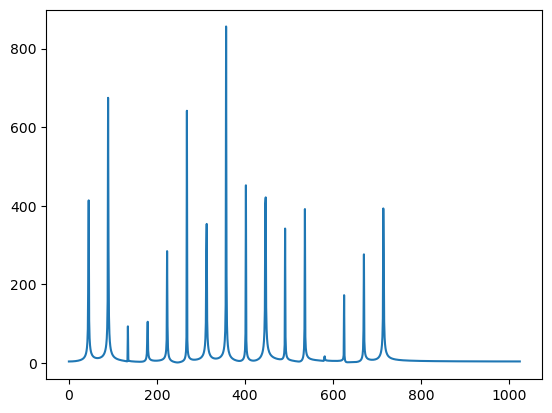

In [101]:
target_model = HarmonicModel(n_harmonics).requires_grad_(False)
target_signal = target_model(n)
plt.plot(torch.fft.rfft(target_signal).abs())

In [102]:
model = HarmonicModel(n_harmonics)
sinusoidal_model = SinusoidalModel(n_harmonics)
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(sinusoidal_model.parameters()), lr=1e-4
)
loss_fn = partial(fft_loss, lin_l1=0.0, lin_huber=1.0, huber_delta=1.00)


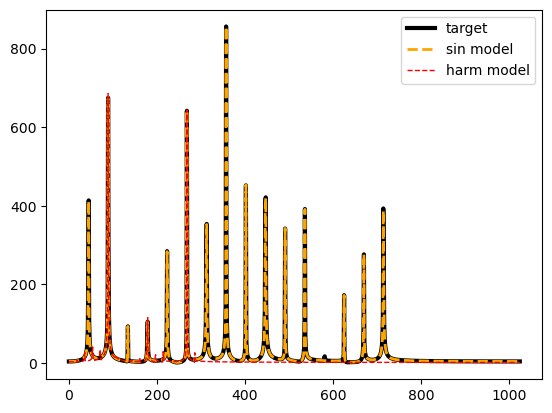

In [103]:
torch.autograd.set_detect_anomaly(False)

steps = 100000

losses = []
for step in range(steps):
    optimizer.zero_grad()
    signal = sinusoidal_model(n)
    harm_signal = model(n)
    sig_loss = loss_fn(signal, target_signal)
    harm_sig_loss = loss_fn(harm_signal, target_signal)
    # lap_loss = min_lap_cost(model.freq, sinusoidal_model.freq.angle().detach(), model.amp, sinusoidal_model.amp.detach())
    sinusoidal_amp = sinusoidal_model.amp.detach() * estimate_amplitude(sinusoidal_model.freq.detach()[None], N, representation="fft")
    consistency_loss = kde_consistency_loss(
        model.amp.detach(), model.freq, sinusoidal_amp, sinusoidal_model.freq.angle().detach()
    )
    loss = sig_loss + harm_sig_loss + 0.1 * consistency_loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if step % 500 == 0:
        with torch.no_grad():
            plt.plot(
                torch.fft.rfft(target_signal).abs(),
                color="black",
                label="target",
                linewidth=3,
            )
            plt.plot(
                torch.fft.rfft(sinusoidal_model(n)).abs(),
                "--",
                color="orange",
                label="sin model",
                linewidth=2,
            )
            plt.plot(
                torch.fft.rfft(model(n)).abs(),
                "--",
                color="red",
                label="harm model",
                linewidth=1,
            )
            plt.legend()

            ipd.clear_output()
            plt.show()
    if step % 50 == 0:
        print(f"Step {step}: {loss.item()}", end="\r")


In [ ]:
69 + 12 * torch.log2((44100 * torch.arange(1, n_harmonics + 1) * model.f0 / math.tau) / 440.0)

tensor([ 66.4264,  78.4264,  85.4460,  90.4264,  94.2895,  97.4460, 100.1147,
        102.4264, 104.4655, 106.2895, 107.9396, 109.4460, 110.8317, 112.1147,
        113.3091, 114.4264, 115.4760, 116.4655, 117.4015, 118.2895, 119.1342,
        119.9396, 120.7092, 121.4460, 122.1527, 122.8317, 123.4851, 124.1147,
        124.7222, 125.3091, 125.8768, 126.4264, 126.9591, 127.4760, 127.9778,
        128.4655, 128.9398, 129.4015, 129.8512, 130.2896],
       grad_fn=<AddBackward0>)

In [ ]:
69 + 12 * torch.log2((44100 * torch.arange(1, n_harmonics + 1) * target_model.f0 / math.tau) / 440.0)

tensor([ 61.7898,  73.7898,  80.8093,  85.7898,  89.6529,  92.8093,  95.4780,
         97.7898,  99.8289, 101.6529, 103.3030, 104.8093, 106.1951, 107.4780,
        108.6725, 109.7898, 110.8393, 111.8289, 112.7649, 113.6529, 114.4976,
        115.3030, 116.0725, 116.8093, 117.5161, 118.1951, 118.8484, 119.4780,
        120.0856, 120.6725, 121.2401, 121.7898, 122.3225, 122.8393, 123.3412,
        123.8289, 124.3032, 124.7649, 125.2146, 125.6529])